In [1]:
# Variational Autoencoder implementation
# https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist

In [3]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean over the last axis
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    
    # Alternative
    #lh = tf.distributions.Bernoulli(probs=y_pred)
    #return - K.sum(lh.log_prob(y_true), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

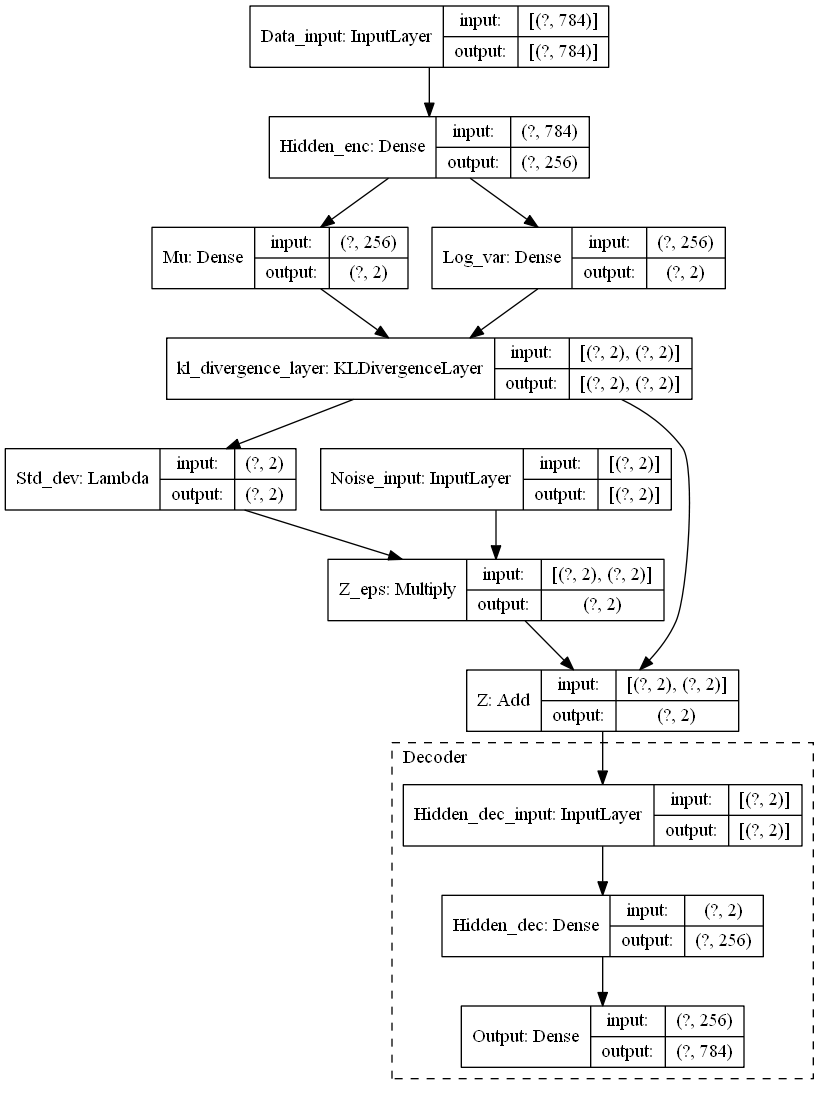

In [4]:
# VAE model
original_dim = 784 # flattened MNIST 28x28
intermediate_dim = 256
latent_dim = 2

# Encoder
x = Input(shape=(original_dim,), name='Data_input')
eps = Input(shape=(latent_dim,), name='Noise_input')

h = Dense(intermediate_dim, activation='relu', name='Hidden_enc') (x)

z_mu = Dense(latent_dim, name='Mu') (h)
z_log_var = Dense(latent_dim, name='Log_var') (h)

# Only adds KL divergence to loss, output = input
# Log variance is used for increased numerical stability
z_mu, z_log_var = KLDivergenceLayer() ([z_mu, z_log_var])

# Standard deviation is needed, calculate it from log variance
z_std_dev = Lambda(lambda t: K.exp(.5*t), name='Std_dev') (z_log_var)

z_eps = Multiply(name='Z_eps') ([z_std_dev, eps])
z = Add(name='Z')([z_mu, z_eps])

encoder = Model(x, z_mu, name='Encoder')

# Decoder
decoder = Sequential(name='Decoder')
decoder.add(Dense(intermediate_dim, input_dim=latent_dim, activation='relu', name='Hidden_dec'))
decoder.add(Dense(original_dim, activation='sigmoid', name='Output'))

# Assemble VAE
vae = Model(inputs=[x, eps], outputs=decoder(z))
vae.compile(optimizer='adam', loss=nll)

# Plot model
plot_model(vae,
           to_file='vae.png',
           show_shapes=True,
           expand_nested=True)

In [5]:
# Train the VAE on MNIST digits
# Data input
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

# Noise input
epsilon_std = 1.0
noise_input_train = np.random.normal(0, epsilon_std, size=(len(x_train),latent_dim))
noise_input_test  = np.random.normal(0, epsilon_std, size=(len(x_test),latent_dim))

# Train
history = vae.fit(x=[x_train, noise_input_train],
                  y=x_train,
                  shuffle=True,
                  epochs=20,
                  batch_size=64,
                  validation_data=([x_test, noise_input_test], x_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 99us/sample - loss: 191.7454 - val_loss: 171.2421
Epoch 2/20
60000/60000 [==============================] - 6s 93us/sample - loss: 168.0446 - val_loss: 166.1245
Epoch 3/20
60000/60000 [==============================] - 6s 94us/sample - loss: 164.6153 - val_loss: 163.7051
Epoch 4/20
60000/60000 [==============================] - 6s 95us/sample - loss: 162.5904 - val_loss: 161.9837
Epoch 5/20
60000/60000 [==============================] - 6s 95us/sample - loss: 161.0363 - val_loss: 160.9252
Epoch 6/20
60000/60000 [==============================] - 5s 82us/sample - loss: 159.6306 - val_loss: 159.5905
Epoch 7/20
60000/60000 [==============================] - 5s 86us/sample - loss: 158.3686 - val_loss: 158.5011
Epoch 8/20
60000/60000 [==============================] - 6s 97us/sample - loss: 157.3184 - val_loss: 157.4986
Epoch 9/20
60000/60000 [==============================] - 5s 9

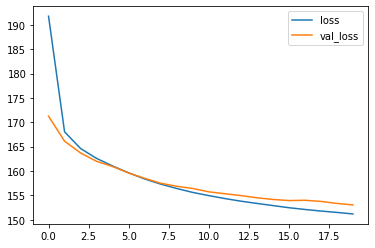

In [6]:
# Training losses
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

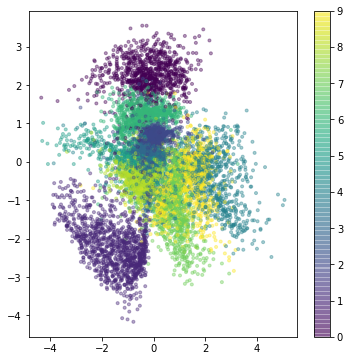

In [7]:
# Display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=50)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

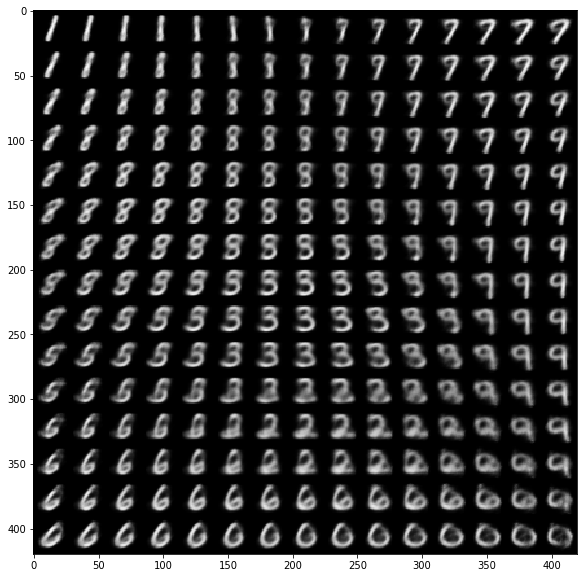

In [8]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()